# ISIMIP3b: analysis of projected climate changes on glacier level

In [1]:
# path to isimip3b files that are available under https://cluster.klima.uni-bremen.de/~lschuster/isimip3b/: this might need to be changed if used on another computer
path = 'isimip3b/'


In [2]:
import xarray as xr
import numpy as np
from oggm import utils
import matplotlib.pyplot as plt
import pandas as pd
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
#import xesmf as xe
import warnings
import progressbar
from scipy import stats
import seaborn as sns
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

## some preprocessing to get the glacier gridpoints and their area

In [3]:
ds_inv = xr.open_dataset('orog_W5E5v1.0.nc')
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

# get the dataset where coordinates of glaciers are stored
frgi = 'rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)

nx, ny = ds_inv.dims['lon'], ds_inv.dims['lat']
# Nearest neighbor lookup
cenlon_for_bins = np.where(odf['CenLon'] < -0.125, odf['CenLon']+360, odf['CenLon']) # just make them into 0-> 360 scheme
lon_bins = np.linspace(0, 360, nx) # np.linspace(-0.125, 359.75+0.125, nx)
lat_bins = np.linspace(90, -90, ny)  #  np.linspace(90+0.125, -90-0.125, ny)
odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1

# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of W5E5 gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

# this is the mask that we need to remove all non-glacierized gridpoints
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area'] # 1
ds_inv['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))

ds_inv['glacier_area'] = (('lat', 'lon'), mask)
ds_inv['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

reg = np.full((ny, nx), np.NaN)
reg[mdf['lat_id'], mdf['lon_id']] = mdf['O1Region'].astype(int)
ds_inv['rgi_region'] = (('lat', 'lon'), reg)


# Weight
weight = np.cos(np.deg2rad(ds_inv.lat.astype(np.float64))).clip(0)
weight =  ds_inv.orog * 0. + weight

ds_inv['weight'] = (('lat', 'lon'), weight / weight.sum())

Total number of glaciers: 216502 and number of W5E5 gridpoints with glaciers in them: 4713


In [4]:
print('total glacier area: {} km2'.format(np.nansum(mask)) )

total glacier area: 746092.8810000002 km2


In [5]:
# this should be one
print(ds_inv['weight_glacier'].sum())

<xarray.DataArray 'weight_glacier' ()>
array(1.)


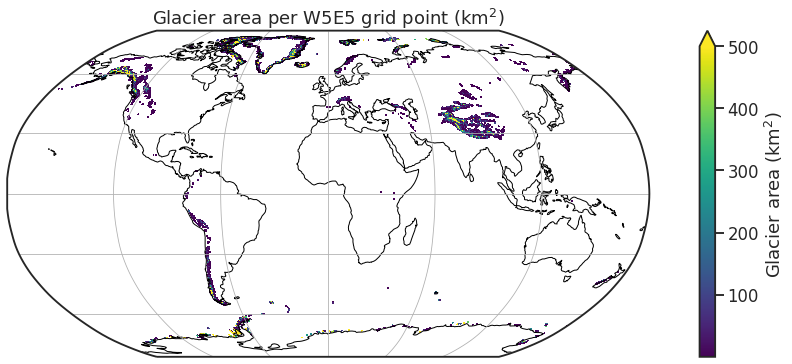

In [6]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ds_inv['glacier_area'].plot(ax=ax, transform=ccrs.PlateCarree(), vmax=500, 
                            cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per W5E5 grid point (km$^{2}$)');

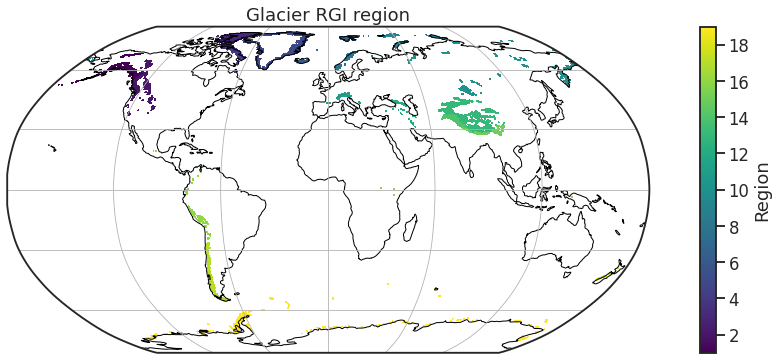

In [7]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ds_inv['rgi_region'].plot(ax=ax, transform=ccrs.PlateCarree(), 
                            cbar_kwargs={'label':'Region'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier RGI region');

## Global climate time series of only glacier regions (weighted by glacier area)

**first get the annual global mean time series for each scenario and ensemble**

In [31]:
ds_inv.coords['lon'] = np.where(ds_inv.lon.values > 180, ds_inv.lon.values - 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_neg_pos'

dict_global_pr_mean_g= {}
dict_global_tas_mean_g= {}
dict_global_tas_daily_std_g = {}

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']

for gcm in gcms:
    if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
        ensemble = 'r1i1p1f1'
    elif gcm == 'ukesm1-0-ll':
        ensemble = 'r1i1p1f2'
    for scenario in scenarios:
        print(gcm, ensemble, scenario)

        if scenario == 'historical':
            ybegin = 1850
            yend = 2014
        else:
            ybegin = 2015
            yend = 2100    

        typ = 'prAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_pr = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        typ = 'tasAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_tas = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
        path_output_tas_std = 'isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)


        ds_pr_monthly = xr.open_dataset(path_output_pr)
        ds_tas_monthly = xr.open_dataset(path_output_tas)
        ds_tas_daily_std = xr.open_dataset(path_output_tas_std)


        # get the global means for every month:
        global_pr_mean_g = (ds_pr_monthly.prAdjust * ds_inv.weight_glacier).sum(dim=['lon','lat']).resample(time='1Y').mean() *60*60*24  # from kg /m2 /s to  mm/day
        global_tas_mean_g = (ds_tas_monthly.tasAdjust* ds_inv.weight_glacier).sum(dim=['lon','lat']).resample(time='1Y').mean() - 273.15  # from K to °C
        global_tas_daily_std_g = (ds_tas_daily_std.tasAdjust_std* ds_inv.weight_glacier).sum(dim=['lon','lat']).resample(time='1Y').mean() #- 273.15  # from K to °C

        print('global glacier precipitation mean: {} mm/day \nglobal glacier temperature mean: {} °C'.format(global_pr_mean_g.mean().values.round(2), global_tas_mean_g.mean().values.round(2)))

        dict_global_pr_mean_g['{}_{}'.format(gcm, scenario)] = global_pr_mean_g
        dict_global_tas_mean_g['{}_{}'.format(gcm, scenario)] = global_tas_mean_g
        dict_global_tas_daily_std_g['{}_{}'.format(gcm, scenario)] = global_tas_daily_std_g





gfdl-esm4 r1i1p1f1 historical
global glacier precipitation mean: 1.98 mm/day 
global glacier temperature mean: -9.52 °C
gfdl-esm4 r1i1p1f1 ssp126
global glacier precipitation mean: 2.1 mm/day 
global glacier temperature mean: -7.81 °C
gfdl-esm4 r1i1p1f1 ssp370
global glacier precipitation mean: 2.16 mm/day 
global glacier temperature mean: -6.6 °C
gfdl-esm4 r1i1p1f1 ssp585
global glacier precipitation mean: 2.18 mm/day 
global glacier temperature mean: -6.32 °C
ipsl-cm6a-lr r1i1p1f1 historical
global glacier precipitation mean: 1.92 mm/day 
global glacier temperature mean: -10.41 °C
ipsl-cm6a-lr r1i1p1f1 ssp126
global glacier precipitation mean: 2.13 mm/day 
global glacier temperature mean: -7.0 °C
ipsl-cm6a-lr r1i1p1f1 ssp370
global glacier precipitation mean: 2.25 mm/day 
global glacier temperature mean: -5.42 °C
ipsl-cm6a-lr r1i1p1f1 ssp585
global glacier precipitation mean: 2.33 mm/day 
global glacier temperature mean: -4.56 °C
mpi-esm1-2-hr r1i1p1f1 historical
global glacier preci

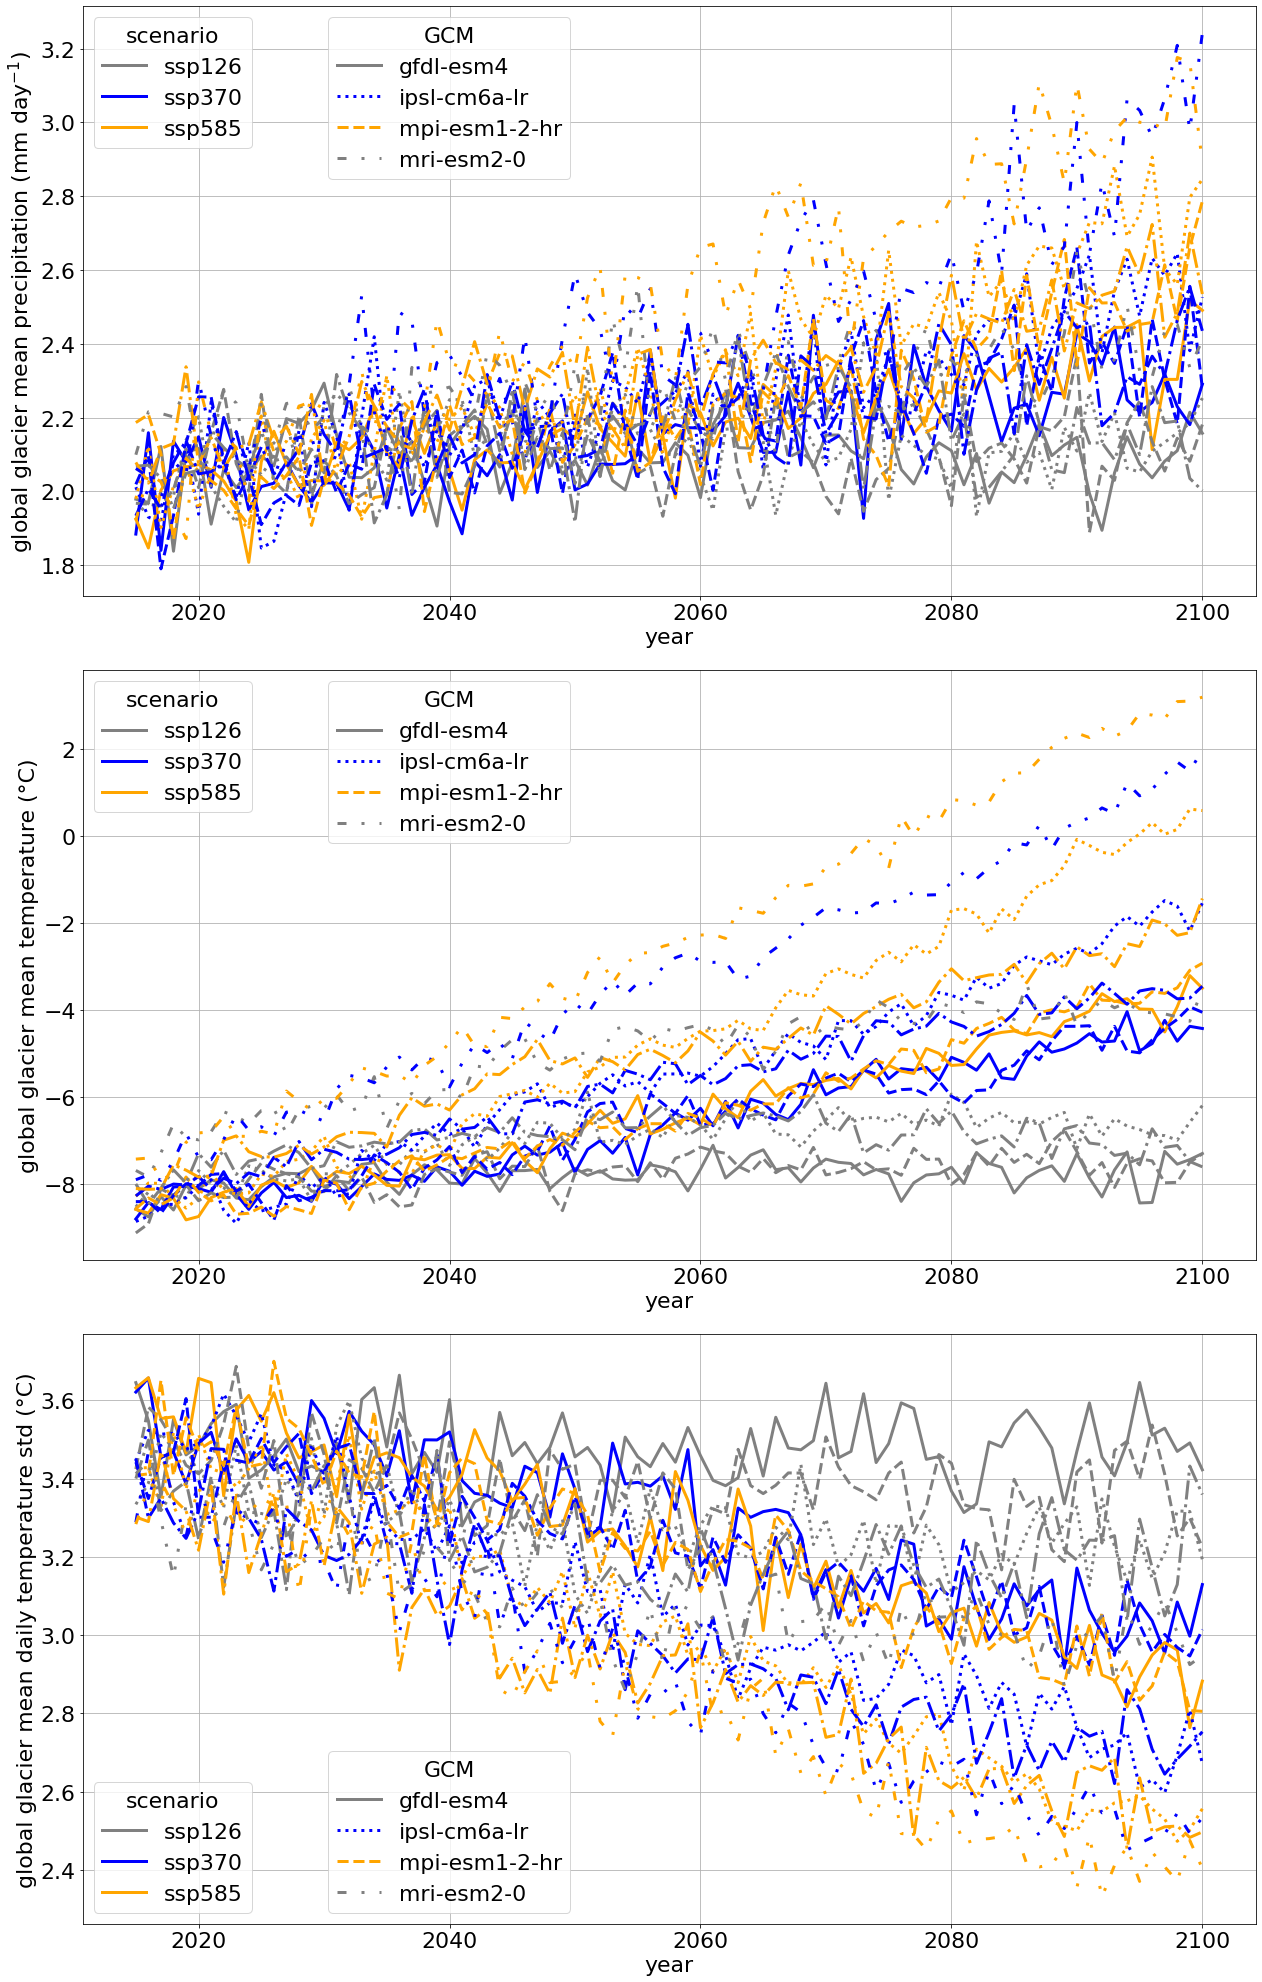

In [45]:
plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,28))

lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        # ax1 = plt.subplot(2,1,1)
        ax1.plot(yr, dict_global_pr_mean_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax1.set_ylabel(r'global glacier mean precipitation (mm day$^{-1}$)')
        ax1.set_xlabel('year')
        if ls == '-':
            legend1 = ax1.legend(loc=2, title = 'scenario')
        # ax2.subplot(2,1,2)
        ax2.plot(yr, dict_global_tas_mean_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls = ls, lw=3)
        ax2.set_ylabel('global glacier mean temperature (°C)')
        ax2.set_xlabel('year')
        if ls == '-':
            legend12 = ax2.legend(loc=2, title = 'scenario')
        ###
        ax3.plot(yr, dict_global_tas_daily_std_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls = ls, lw=3)
        ax3.set_ylabel('global glacier mean daily temperature std (°C)')
        ax3.set_xlabel('year')
        if ls == '-':
            legend13 = ax3.legend(loc=3, title = 'scenario')
        
lines = ax1.get_lines()
legend2 = ax1.legend(lines[::4], gcms , loc=2, bbox_to_anchor=(0.2,1), title='GCM')
ax1.add_artist(legend1)

lines = ax2.get_lines()
legend22 = ax2.legend(lines[::4], gcms , loc=2, bbox_to_anchor=(0.2,1), title='GCM')
ax2.add_artist(legend12)

lines = ax3.get_lines()
legend23 = ax3.legend(lines[::4], gcms , loc=3, bbox_to_anchor=(0.2,0), title='GCM')
ax3.add_artist(legend13)
plt.tight_layout()
ax1.grid()
ax2.grid()
ax3.grid()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_mean_time_series.pdf');

# ISIMIP3b average Temperature change at glacier locations for each region separately

In [33]:
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
typs = ['tasAdjust']
scenarios = ['ssp126', 'ssp370', 'ssp585']
tdf_d = {}
taf_d = {}
for scenario in scenarios:
    tdf = pd.DataFrame(dtype=float)
    taf = pd.DataFrame(dtype=float)

    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'

            # for the ssp:
        ybegin = 2015
        yend = 2100
        for typ in typs:
            folder_output = 'isimip3b_{}_monthly'.format(typ)

            path = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
            path_h = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, 'historical', typ, 1850, 2014)

            ds_gcm_t2m_hist = xr.open_dataset(path_h).tasAdjust-273.15
            ds_gcm_t2m = xr.open_dataset(path).tasAdjust-273.15
            ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                         ds_gcm_t2m.lon.values + 360,
                                         ds_gcm_t2m.lon.values)
            ds_gcm_t2m['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                         ds_gcm_t2m.lon.values + 360,
                                         ds_gcm_t2m.lon.values)

            # could also look at the seasonal cycle, but here I look at the annual means ...
            mean = (ds_gcm_t2m.groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])
            mean_hist = (ds_gcm_t2m_hist.groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])


            
            # amount of warming for each grid point 
            t2m_dT = ds_gcm_t2m.sel(time=slice('2086','2100')).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice('2000', '2014')).mean(dim='time')
            # ... divided by GMT warming 
            t2m_dT_per_dT = t2m_dT / (mean.sel(year=slice(2086, 2100)).mean()-mean_hist.sel(year=slice(2000,2014)).mean())

            # Check (should be one)
            tdf.loc['GMT', gcm] = float((t2m_dT_per_dT * ds_inv.weight).sum(dim=['lon','lat']))

            # these should be the same ... 
            taf.loc['GMT', gcm] = float((t2m_dT * ds_inv.weight).sum(dim=['lon','lat']))
            taf.loc['GMT_mean_diff', gcm] = (mean.sel(year=slice(2086, 2100)).mean()-mean_hist.sel(year=slice(2000,2014)).mean())
            tdf.loc['GMT_mean_diff', gcm] = (mean.sel(year=slice(2086, 2100)).mean()-mean_hist.sel(year=slice(2000,2014)).mean())

            # All glaciers (weighted by area)
            # in weight_glacier: the area of each glacier is already inside
            tdf.loc['All', gcm] = float((t2m_dT_per_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))
            taf.loc['All', gcm] = float((t2m_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))

            for rgi_reg in range(1, 20):
                weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
                weight_reg = weight_reg / weight_reg.sum()

                tdf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_per_dT * weight_reg).sum(dim=['lon','lat']))
                taf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT * weight_reg).sum(dim=['lon','lat']))

            tdf_d[scenario] = tdf
            taf_d[scenario] = taf

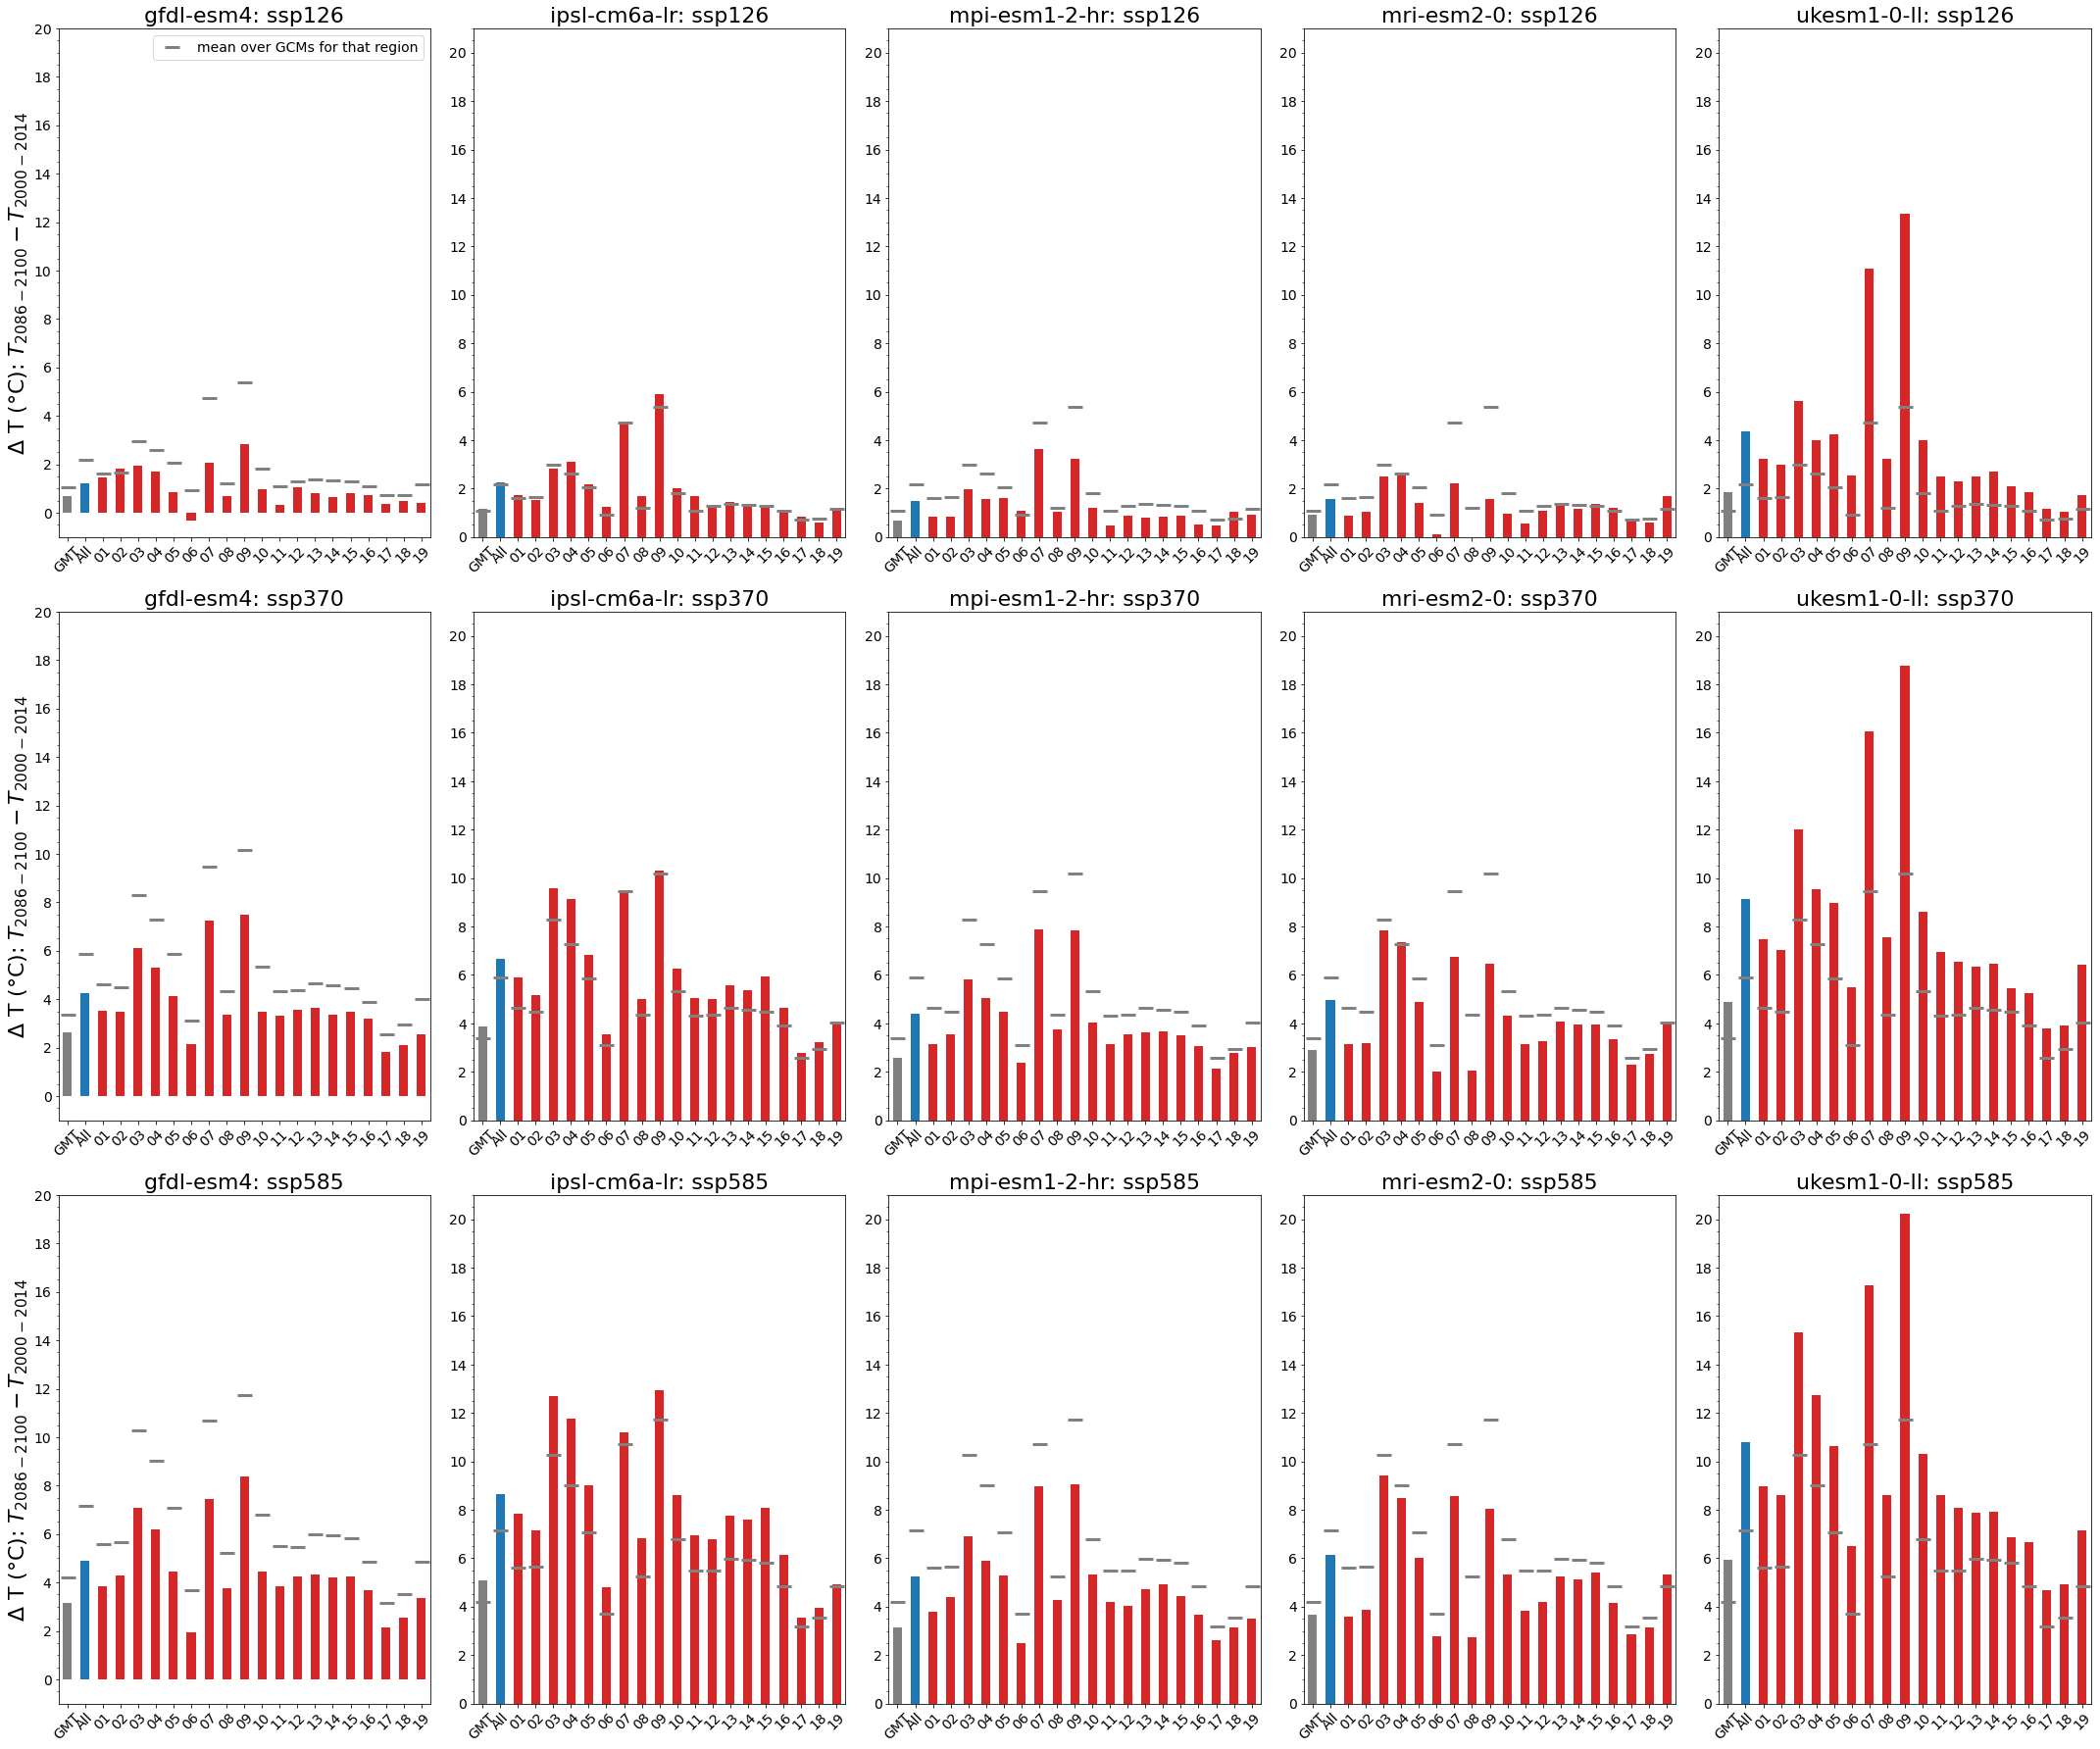

In [43]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(30, 25))

j=0
for scenario in scenarios:
    for gcm in gcms:

        #tdf_d[scenario].loc['frac_mean_GMT'] = tdf_d[scenario].loc['GMT_mean_diff']/tdf_d[scenario].loc['GMT_mean_diff'].mean()
        plt.subplot(3,5,j+1)
        ax = plt.gca()
        #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
        plt.plot(taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
                 taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
                label='mean over GCMs for that region')
        if gcm==gcms[0]:
            plt.ylabel('$\Delta$ T (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=22)
            plt.ylim(-1, 15)
        else:
            plt.ylim(0,21)
        plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
        plt.minorticks_on() # (np.arange(0,19))
        plt.yticks(np.arange(0,22,2))
        ax.tick_params(axis='x',which='minor',bottom=False)
        if j==0:
            plt.legend(fontsize=22)
        taf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);

        j+=1
#plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
plt.tight_layout()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT.pdf')

we can recognize that:
- for all scenarios and gcms, glaciers will experience more warming
- however, the warming is very different for each region 
    - strongest warming in RGI 3,4, 7, 9
    - smallest warming in RGI 5, 17, 18
        - even some cooling in case of RGI 5 and RGI 7 for SSP126 for some ensembles
- ukesm has the largest temperature variations in between the regions

**same but as mean over GCMs with std of GCMs**

(mean corresponds to the grey lines that were visible in the plot above)

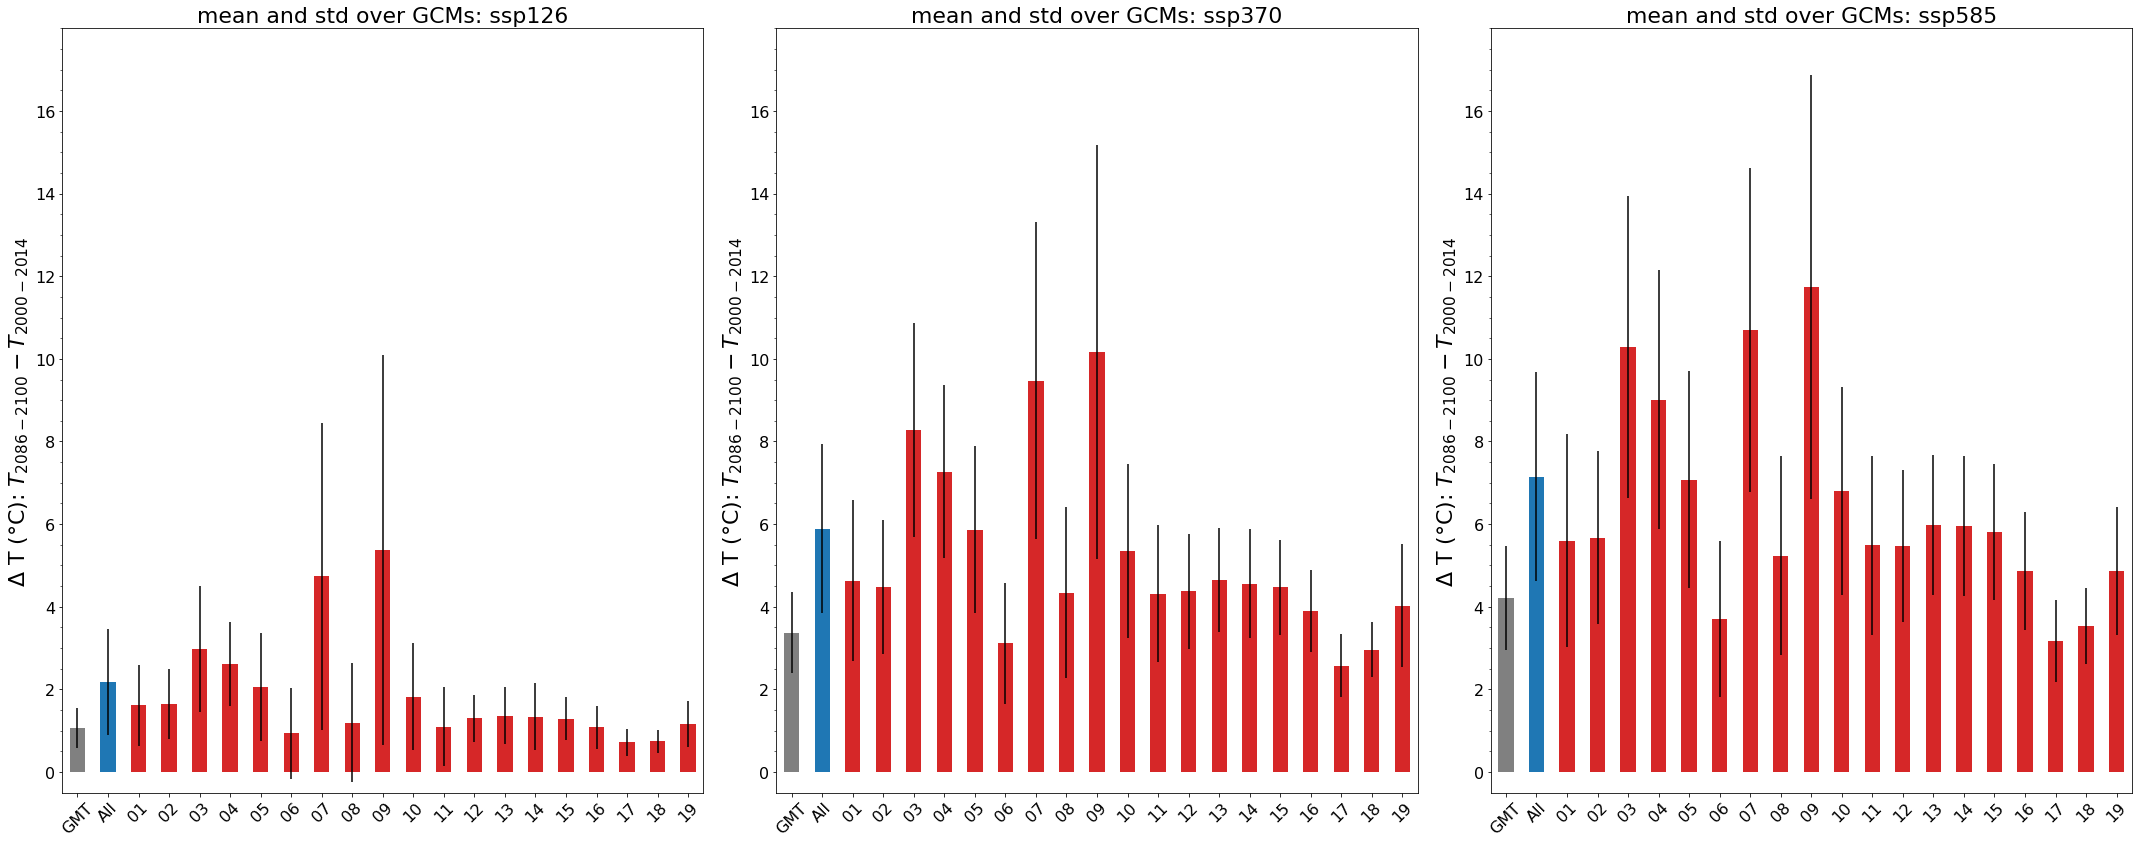

In [42]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(30, 12))

j=0
for scenario in scenarios:
        #for gcm in gcms:

        #tdf_d[scenario].loc['frac_mean_GMT'] = tdf_d[scenario].loc['GMT_mean_diff']/tdf_d[scenario].loc['GMT_mean_diff'].mean()
        plt.subplot(1,3,j+1)
        ax = plt.gca()
        #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
        #plt.plot(taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
        #         taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
        #        label='mean over GCMs for that region')
        #if gcm==gcms[0]:
        plt.ylabel('$\Delta$ T (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=22)
        plt.ylim(-0.5, 18)
        plt.title('mean and std over GCMs: {}'.format(scenario), fontsize=22)
        plt.minorticks_on() # (np.arange(0,19))
        plt.yticks(np.arange(0,18,2))
        ax.tick_params(axis='x',which='minor',bottom=False)
        #if j==0:
        #    plt.legend(fontsize=22)
        yerr = taf_d[scenario].drop('GMT_mean_diff').std(axis=1)
        taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey'], yerr=yerr);
                                                               #label='mean and std over GCMs');

        j+=1
#plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
plt.tight_layout()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_mean_std.pdf')



### gridpoint temperature warming per GMT warming

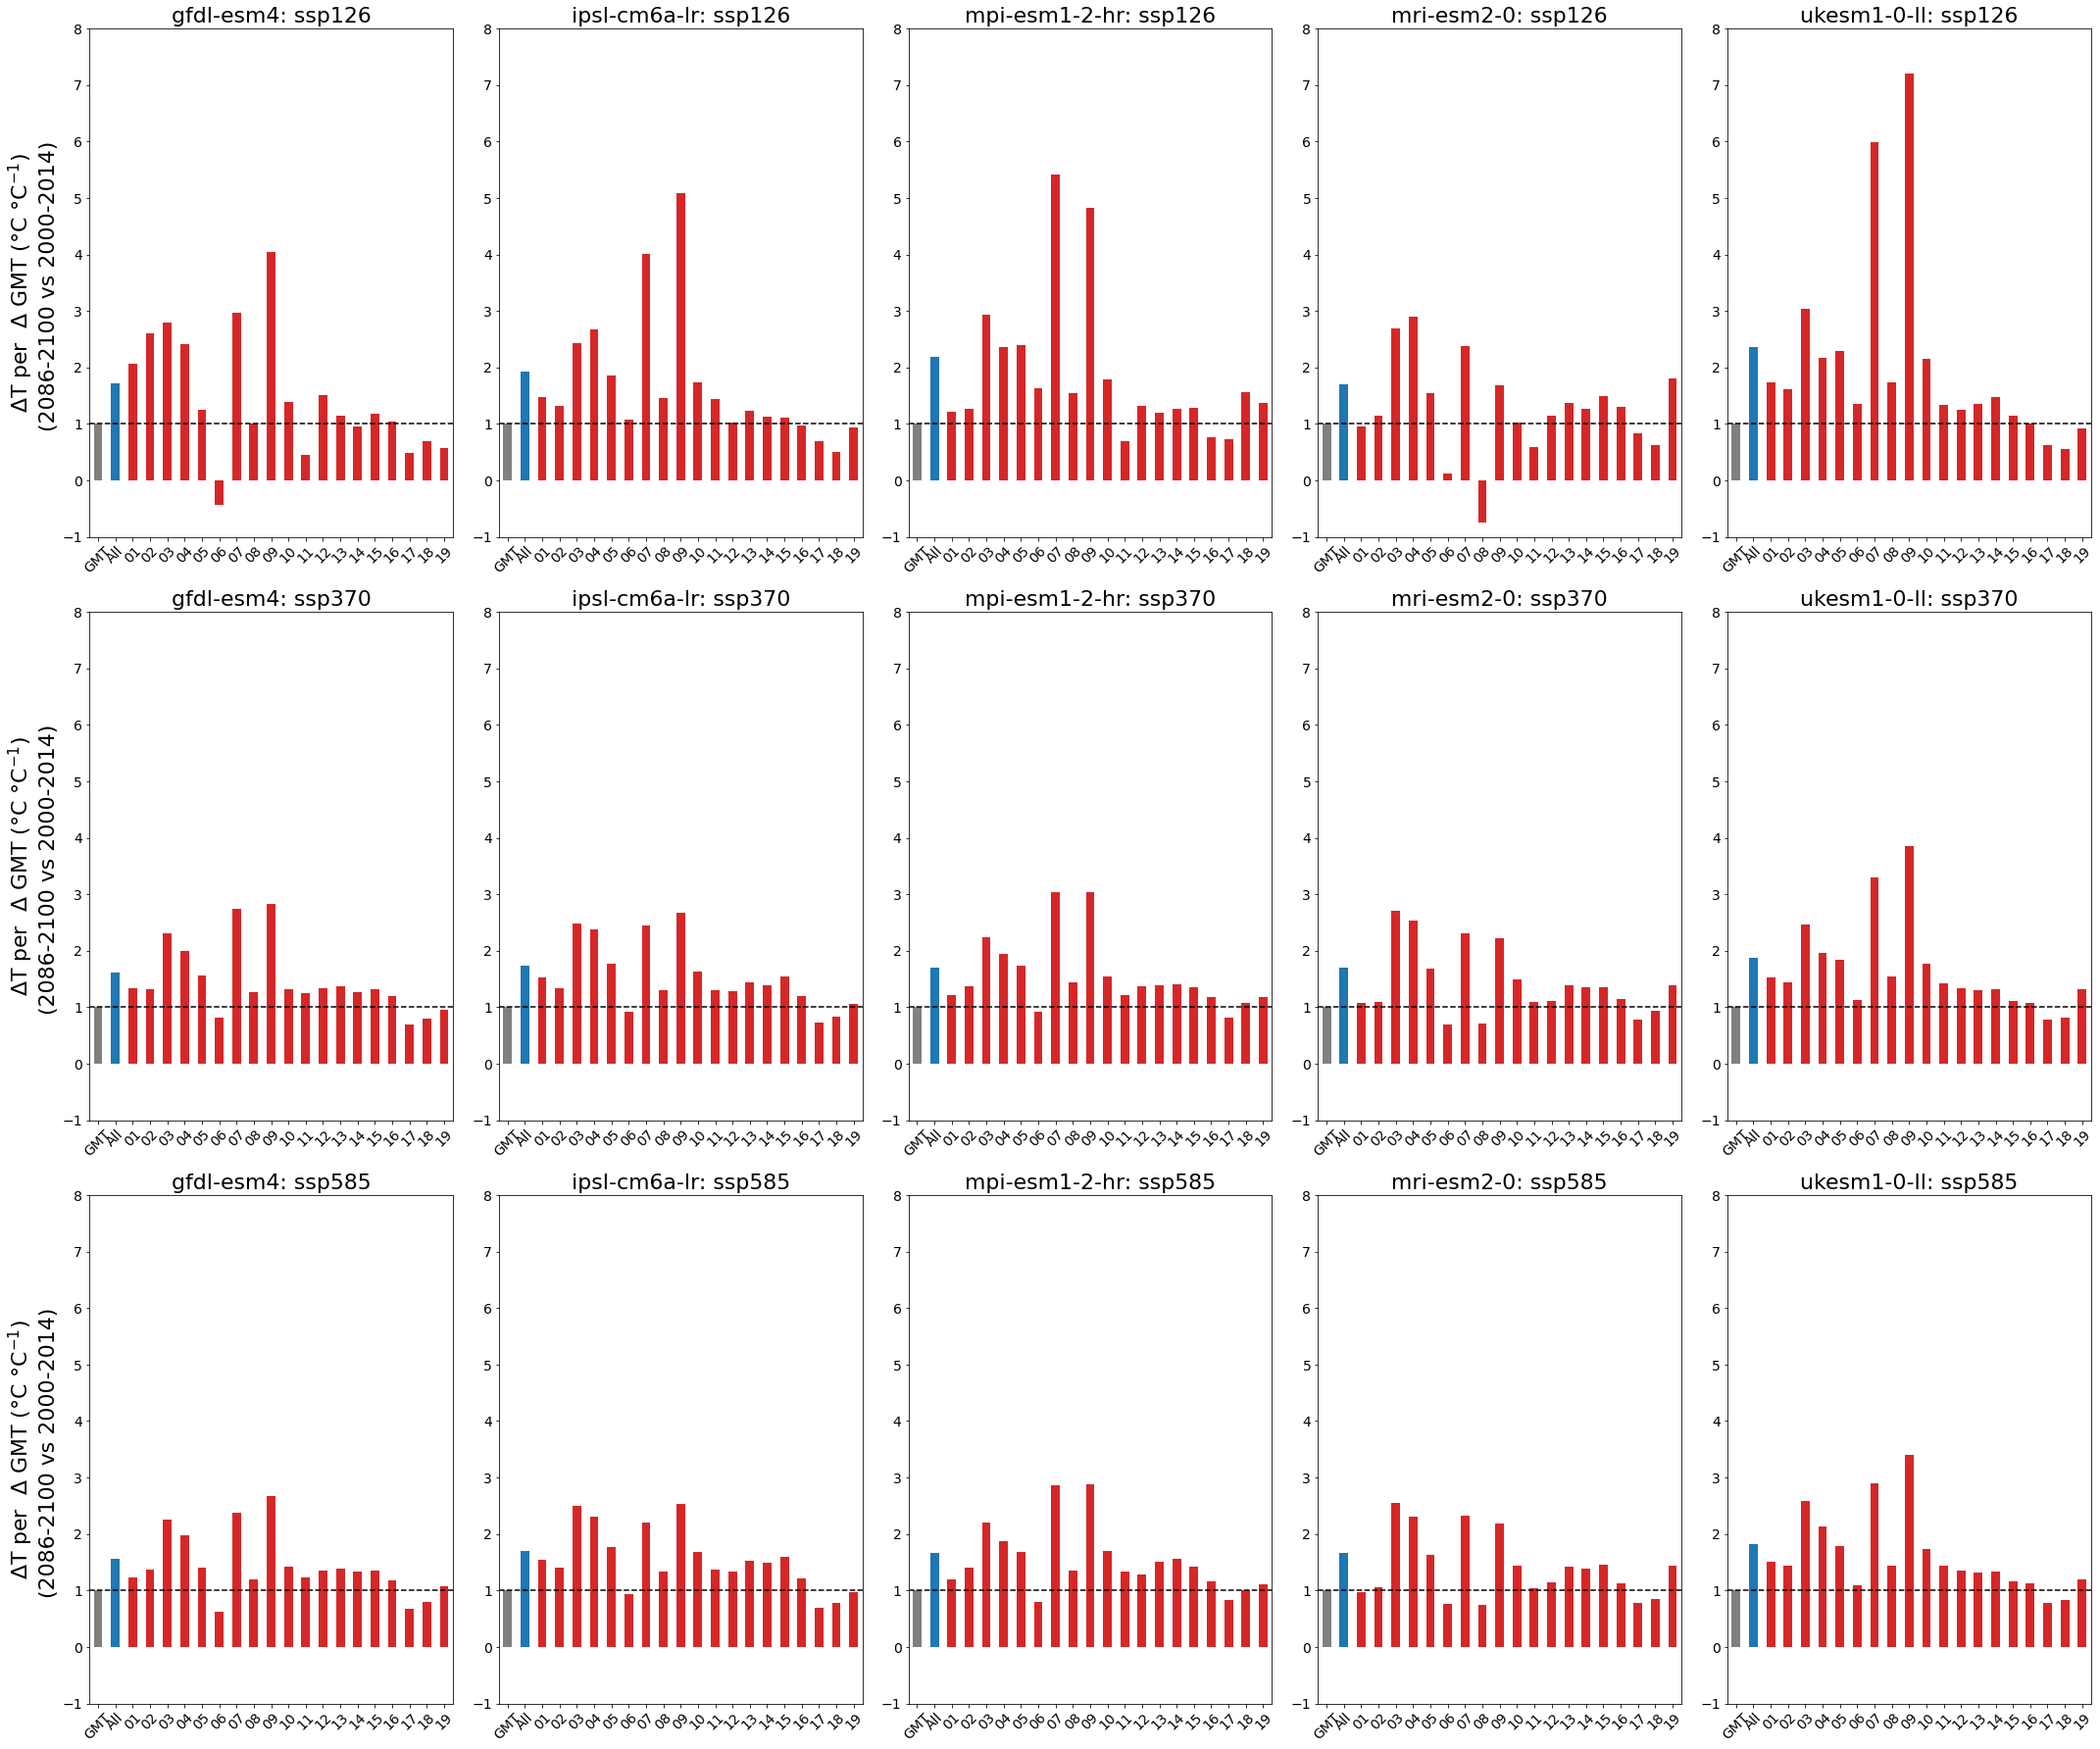

In [46]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(30, 25))


j=0
for scenario in scenarios:
    for gcm in gcms:

        plt.subplot(3,5,j+1)
        ax = plt.gca()
        plt.axhline([1], linestyle='--', color='k')
        tdf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);
        if gcm == gcms[0]:
            plt.ylabel('$\Delta$T per  $\Delta$ GMT (°C °C$^{-1}$)\n(2086-2100 vs 2000-2014) ', fontsize=22)
        plt.ylim(-1, 8)
        plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
        j+=1
plt.tight_layout()
#plt.suptitle(f'ISIMIP3b average T change at glacier locations per degree global warming(°C per GMT °C) 2086-2100 vs 2000-2014')

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_per_deltaGMT.pdf')

- "1" means here that warming in this region is same as the global mean temperature warming for that scenario and that GCM
    - so it only shows the relative changes and is difficult to compare!